In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import random
from torch import optim
import matplotlib.pyplot as plt
from typing import List
from utils import *
from torch.utils.data import Dataset, DataLoader, RandomSampler
import tqdm
from scipy.stats import ttest_ind
# from bus_transformer import *
from datasets import load_dataset
import datasets
from transformers import AutoTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 128 
batch_size = 16 
print(DEVICE)

cuda


- limit sequences to 128
- limit tasks to sentence classification
- use single sequence training without NSP
- 


In [23]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, d_internal):
        super().__init__()

        self.W_Q = torch.nn.Linear(d_model, d_internal, False)
        self.W_K = torch.nn.Linear(d_model, d_internal, False)
        self.W_V = torch.nn.Linear(d_model, d_internal, False)

        self.SoftMax = torch.nn.Softmax(dim=-1)


        self.d_model = d_model
        self.d_internal = d_internal
        self.norm = torch.tensor(d_model**-0.5)
        self.tril = torch.tril(torch.ones(seq_len, seq_len, device=DEVICE))

    def expand(self, d_mnew, d_inew):

        self.W_Q.weight.data = torch.cat([self.W_Q.weight.data, torch.zeros(d_inew - self.d_internal, self.d_model, device=DEVICE)], dim=0)
        self.W_Q.weight.data = torch.cat([self.W_Q.weight.data, torch.zeros(d_inew, d_mnew - self.d_model, device=DEVICE)], dim=1)
        for i in range(self.d_internal, d_inew):
            self.W_Q.weight.data[i][i] = self.W_Q.weight.data[i][i] if self.W_Q.weight.data[i][i] != 0 else 1

        self.W_K.weight.data = torch.cat([self.W_K.weight.data, torch.zeros(d_inew - self.d_internal, self.d_model, device=DEVICE)], dim=0)
        self.W_K.weight.data = torch.cat([self.W_K.weight.data, torch.zeros(d_inew, d_mnew - self.d_model, device=DEVICE)], dim=1)
        for i in range(self.d_internal, d_inew):
            self.W_K.weight.data[i][i] = self.W_K.weight.data[i][i] if self.W_K.weight.data[i][i] != 0 else 1

        self.W_V.weight.data = torch.cat([self.W_V.weight.data, torch.zeros(d_inew - self.d_internal, self.d_model, device=DEVICE)], dim=0)
        self.W_V.weight.data = torch.cat([self.W_V.weight.data, torch.zeros(d_inew, d_mnew - self.d_model, device=DEVICE)], dim=1)
        for i in range(self.d_internal, d_inew):
            self.W_V.weight.data[i][i] = self.W_V.weight.data[i][i] if self.W_V.weight.data[i][i] != 0 else 1

        self.d_internal = d_inew
        self.d_model = d_mnew 
        self.SoftMax = torch.nn.Softmax(dim=-1)
        self.tril = torch.tril(torch.ones(seq_len, seq_len, device=DEVICE))



    def forward(self, input_vecs):
        B, T, C = input_vecs.shape

        Q = self.W_Q(input_vecs)
        K = self.W_K(input_vecs)
        V = self.W_V(input_vecs)

        weights = Q @ K.transpose(-2, -1) * C**-0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        Attn = self.SoftMax(weights)


        out = Attn @ V

        return out

In [79]:
class Transformer(nn.Module):
    def __init__(self, d_model, vocab_size, num_heads, d_hidden):
        super().__init__()
        self.d_model = d_model
        self.d_internal = d_model//num_heads
        self.num_heads = num_heads
        self.vocab_size = vocab_size 
        self.d_hidden = d_hidden

        self.heads = nn.ModuleList([AttentionHead(d_model, self.d_internal) for _ in range(num_heads)])
        self.Softmax = torch.nn.LogSoftmax(dim=-1)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(self.d_model, self.d_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(self.d_hidden, self.d_model),
        )
        self.W_O = torch.nn.Linear(d_model, d_model, False)
        self.layernorm = torch.nn.LayerNorm(d_model)



    def forward(self, x):
        """
        :param x: input embeddings 
        :return: output of decoder block, same shape as input
        """
        t = x
        t = torch.cat([head(t) for head in self.heads], dim=-1)
        t = self.W_O(t)
        t1 = self.layernorm(t + x)
        # t = self.relu(self.cout(self.FFN(self.connection(t1))))
        t = self.FFN(t1)
        t = self.layernorm(t + t1)

        return t



    def expand(self, d_mnew, d_inew):

        # self.connection = torch.nn.Linear(d_mnew, self.d_hidden)
        # self.cout = torch.nn.Linear(self.d_hidden, d_mnew)

        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_mnew, self.d_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(self.d_hidden, d_mnew),
        )
        self.W_O.weight.data = torch.cat([self.W_O.weight.data, torch.zeros(d_mnew-self.d_model, self.d_model, device=DEVICE)], dim=0)
        self.W_O.weight.data = torch.cat([self.W_O.weight.data, torch.zeros(d_mnew, d_mnew-self.d_model,  device=DEVICE)], dim=1)
        self.layernorm = torch.nn.LayerNorm(d_mnew)
        for i in range(self.d_model+1, d_mnew):
            self.W_O.weight.data[i][i] = 1

        for head in self.heads:
            head.expand(d_mnew, d_inew)

        self.Softmax = torch.nn.LogSoftmax(dim=-1)
        self.d_model = d_mnew
        self.d_internal = d_inew
        self.to(DEVICE)




In [74]:
class Decoder(nn.Module):
    def __init__(self, num_blocks, d_model, d_hidden, vocab_size, num_heads):
        super().__init__()
        self.num_blocks = num_blocks
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.SoftMax = torch.nn.LogSoftmax(dim=-1)
        self.blocks = torch.nn.ModuleList([Transformer(d_model, vocab_size, num_heads, d_hidden) for _ in range(num_blocks)])
        self.d_hidden = d_hidden

        # self.connection = torch.nn.Linear(d_model, d_hidden)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_model, vocab_size),
            torch.nn.LogSoftmax(dim=-1),
        )
        self.dout = torch.nn.Dropout(0.1)
        
        self.embeddings = torch.nn.Embedding(vocab_size, d_model, device=DEVICE)
        self.pos_embedding = None
        # self.pos_embedding = torch.nn.Embedding(seq_len, d_model, device=DEVICE)
        self.generate_pos_embed(d_model)
        

    def forward(self, x):
        x = self.embeddings(x) + self.pos_embedding(torch.arange(x.shape[-1], device=DEVICE))
        x = self.dout(x)
        t = x
        for head in self.blocks:
            t = head(t) + t 

        ret = self.FFN(t)

        return ret

    def generate_pos_embed(self, d_model):
        # TODO: make more efficient 
        pos_em = torch.zeros((seq_len, d_model))
        for pos in range(seq_len):
            for i in range(d_model):
                if i % 2 == 0:
                    pos_em[pos][i] += torch.sin(torch.tensor(pos/(10000**(2*i/d_model))))
                else:
                    pos_em[pos][i] += torch.cos(torch.tensor(pos/(10000** (2*i/d_model))))

        self.pos_embedding = torch.nn.Embedding.from_pretrained(pos_em, freeze=True)




    def expand(self, d_mnew):
        d_inew = d_mnew // self.num_heads
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_mnew, self.vocab_size),
            torch.nn.LogSoftmax(dim=-1),
        )

        self.layernorm = torch.nn.LayerNorm(d_mnew, device=DEVICE)
        for block in self.blocks:
            block.expand(d_mnew, d_inew)

        self.embeddings = torch.nn.Embedding.from_pretrained(torch.cat([self.embeddings.weight, torch.zeros(self.vocab_size, d_mnew-self.d_model, device=DEVICE).uniform_()], dim=1))
        # self.pos_embedding = torch.nn.Embedding.from_pretrained(torch.cat([self.pos_embedding.weight, torch.zeros(seq_len, d_mnew-self.d_model, device=DEVICE).uniform_()], dim=1))
        self.generate_pos_embed(d_mnew)
        # self.embeddings = torch.nn.Embedding(self.vocab_size, d_mnew)
        # self.pos_embedding = torch.nn.Embedding(seq_len, d_mnew)

        self.d_model = d_mnew
        self.d_internal = d_inew
        self.to(DEVICE)

In [27]:
model = Decoder(num_blocks=12, d_model=768, d_hidden=768*4, vocab_size=50257, num_heads=12)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

162.342481 M parameters


In [28]:
# data = load_dataset('Salesforce/wikitext', 'wikitext-103-v1')
data = load_dataset('tiny_shakespeare')
train = data['train']
validation = data['validation']
test = data['test']

/home/brian/anaconda3/envs/NLP/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [29]:
train.column_names

['text']

In [30]:
chars = sorted(set(next(iter(train['text']))))
len(chars)


65

In [31]:
chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [32]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [33]:
train = data['train']['text'][0]
validation = data['validation']['text'][0]
test = data['test']['text'][0]

In [34]:
test

"rance ta'en\nAs shall with either part's agreement stand?\n\nBAPTISTA:\nNot in my house, Lucentio; for, you know,\nPitchers have ears, and I have many servants:\nBesides, old Gremio is hearkening still;\nAnd happily we might be interrupted.\n\nTRANIO:\nThen at my lodging, an it like you:\nThere doth my father lie; and there, this night,\nWe'll pass the business privately and well.\nSend for your daughter by your servant here:\nMy boy shall fetch the scrivener presently.\nThe worst is this, that, at so slender warning,\nYou are like to have a thin and slender pittance.\n\nBAPTISTA:\nIt likes me well. Biondello, hie you home,\nAnd bid Bianca make her ready straight;\nAnd, if you will, tell what hath happened,\nLucentio's father is arrived in Padua,\nAnd how she's like to be Lucentio's wife.\n\nBIONDELLO:\nI pray the gods she may with all my heart!\n\nTRANIO:\nDally not with the gods, but get thee gone.\nSignior Baptista, shall I lead the way?\nWelcome! one mess is like to be your cheer:

In [35]:
train_data = encode(train)
train_data[:10]

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47]

In [36]:
val_data = encode(validation)
test_data = encode(test)

In [38]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=256)
model.to(DEVICE)

Decoder(
  (SoftMax): LogSoftmax(dim=-1)
  (blocks): ModuleList(
    (0-3): 4 x Transformer(
      (heads): ModuleList(
        (0-3): 4 x AttentionHead(
          (W_Q): Linear(in_features=64, out_features=16, bias=False)
          (W_K): Linear(in_features=64, out_features=16, bias=False)
          (W_V): Linear(in_features=64, out_features=16, bias=False)
          (SoftMax): Softmax(dim=-1)
        )
      )
      (Softmax): LogSoftmax(dim=-1)
      (FFN): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
      )
      (W_O): Linear(in_features=64, out_features=64, bias=False)
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (FFN): Sequential(
    (0): Linear(in_features=64, out_features=65, bias=True)
    (1): LogSoftmax(dim=-1)
  )
  (dout): Dropout(p=0.1, inplace=False)
  (embeddings): Embedd

In [39]:
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

0.214977 M parameters


In [40]:
def batch(s):
    data = train_data if s == 'train' else val_data
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([torch.tensor(data[i:i+seq_len], device=DEVICE) for i in ix])
    y = torch.stack([torch.tensor(data[i+1:i+seq_len+1], device=DEVICE) for i in ix])
    return x, y

In [41]:
xb, yb = batch('train')
xb

tensor([[32, 46, 39,  ...,  1, 58, 46],
        [ 1, 40, 47,  ..., 42,  1, 63],
        [ 6,  1, 21,  ..., 58,  1, 40],
        ...,
        [54, 39, 61,  ..., 56,  1, 58],
        [52, 53, 58,  ...,  5, 58,  6],
        [60, 43,  1,  ..., 43, 42,  1]], device='cuda:0')

In [42]:
yb

tensor([[46, 39, 58,  ..., 58, 46, 63],
        [40, 47, 58,  ...,  1, 63, 53],
        [ 1, 21,  1,  ...,  1, 40, 43],
        ...,
        [39, 61, 52,  ...,  1, 58, 46],
        [53, 58,  0,  ..., 58,  6,  1],
        [43,  1, 21,  ..., 42,  1, 42]], device='cuda:0')

In [43]:
len(data['test']['text'][0])

55770

In [44]:
max_iters = 5000
eval_interval = 100
eval_iters = 200
test_iters = 1000

In [45]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = batch(split)
            logits= model(X)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = Y.view(B*T)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [46]:
def acc(model):
    model.eval()
    a = []

    for k in range(test_iters):
        X, Y = batch("test")
        logits = torch.argmax(model(X), dim=-1)
        x = [[0. if logits[sample][i] != Y[sample][i] else 1. for i in range(seq_len)] for sample in range(batch_size)]
        a.append(x)
    return torch.mean(torch.tensor(a))

        


In [47]:
def train(model, lr=1e-3, min_lr=1e-6):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iters, min_lr)
    for iter in range(max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, lr {optimizer.param_groups[0]['lr']}")

        # sample a batch of data
        xb, yb = batch('train')

        # evaluate the loss
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = yb.view(B*T)
        loss = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()


In [24]:
model = Decoder(num_blocks=4, d_model=128, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

3.345857 M parameters


In [25]:
train(model)

step 0: train loss 4.1688, val loss 4.1690
step 100: train loss 2.5251, val loss 2.5221
step 200: train loss 2.4296, val loss 2.4312
step 300: train loss 2.3301, val loss 2.3314
step 400: train loss 2.1980, val loss 2.2196
step 500: train loss 2.0995, val loss 2.1247
step 600: train loss 2.0298, val loss 2.0811
step 700: train loss 1.9629, val loss 2.0257
step 800: train loss 1.8915, val loss 1.9733
step 900: train loss 1.8468, val loss 1.9321
step 1000: train loss 1.8003, val loss 1.8927
step 1100: train loss 1.7630, val loss 1.8664
step 1200: train loss 1.7296, val loss 1.8358
step 1300: train loss 1.6972, val loss 1.8303
step 1400: train loss 1.6773, val loss 1.8195
step 1500: train loss 1.6501, val loss 1.7725
step 1600: train loss 1.6232, val loss 1.7389
step 1700: train loss 1.6052, val loss 1.7483
step 1800: train loss 1.6014, val loss 1.7330
step 1900: train loss 1.5839, val loss 1.7124
step 2000: train loss 1.5635, val loss 1.6877
step 2100: train loss 1.5527, val loss 1.6970


In [83]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


# make_dot was moved to https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

In [48]:
def train_transfer(model, transfer_step=900, target_size=1024, lr=1e-3, min_lr=1e-6):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iters, min_lr)
    for iter in range(1, max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1 or iter == 1:
            losses = estimate_loss()
            print(f"step {iter}:\t train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, lr {optimizer.param_groups[0]['lr']}")

        if iter == transfer_step:
        # if iter <= 1000 and iter % 500 == 0:
            model.expand(target_size)
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, 0.5)
            print('at step {}: expanded model to: {} M parameters'.format(iter, sum(p.numel() for p in model.parameters())/1e6))
            model.to('cpu')
            model.to(DEVICE)    # Shortcut to recompile gradient backprop since the model changed sizes
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iters-transfer_step, min_lr)
            loss_func = torch.nn.CrossEntropyLoss()
        # sample a batch of data
        xb, yb = batch('train')

        # evaluate the loss
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = yb.view(B*T)
        loss = loss_func(logits, targets)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [28]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

0.535041 M parameters


In [29]:
train_transfer(model)

step 1: train loss 4.1782, val loss 4.1792
step 100: train loss 2.5954, val loss 2.5947
step 200: train loss 2.4439, val loss 2.4388
step 300: train loss 2.3527, val loss 2.3512
step 400: train loss 2.3144, val loss 2.3242
step 500: train loss 2.2663, val loss 2.2731
step 600: train loss 2.2449, val loss 2.2586
step 700: train loss 2.2024, val loss 2.2258
step 800: train loss 2.1698, val loss 2.1884
step 900: train loss 2.1484, val loss 2.1620
at step 900: expanded model to: 0.903617 M parameters
step 1000: train loss 2.3213, val loss 2.3277
step 1100: train loss 2.2354, val loss 2.2447
step 1200: train loss 2.1777, val loss 2.1962
step 1300: train loss 2.1376, val loss 2.1698
step 1400: train loss 2.1093, val loss 2.1410
step 1500: train loss 2.0825, val loss 2.1281
step 1600: train loss 2.0704, val loss 2.1064
step 1700: train loss 2.0356, val loss 2.0877
step 1800: train loss 2.0014, val loss 2.0619
step 1900: train loss 1.9868, val loss 2.0340
step 2000: train loss 1.9596, val loss

In [30]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200)

0.535041 M parameters
step 1: train loss 4.1879, val loss 4.1874
step 100: train loss 2.5947, val loss 2.5963
step 200: train loss 2.4678, val loss 2.4832
step 300: train loss 2.3692, val loss 2.3674
step 400: train loss 2.3235, val loss 2.3313
step 500: train loss 2.2908, val loss 2.3038
step 600: train loss 2.2499, val loss 2.2672
step 700: train loss 2.2112, val loss 2.2363
step 800: train loss 2.1837, val loss 2.1876
step 900: train loss 2.1567, val loss 2.1801
step 1000: train loss 2.1352, val loss 2.1572
step 1100: train loss 2.1147, val loss 2.1407
step 1200: train loss 2.0904, val loss 2.1069
at step 1200: expanded model to: 0.903617 M parameters
step 1300: train loss 2.3702, val loss 2.3457
step 1400: train loss 2.2460, val loss 2.2537
step 1500: train loss 2.1744, val loss 2.1847
step 1600: train loss 2.1263, val loss 2.1537
step 1700: train loss 2.0795, val loss 2.1132
step 1800: train loss 2.0541, val loss 2.0953
step 1900: train loss 2.0346, val loss 2.0744
step 2000: trai

In [32]:
model = Decoder(num_blocks=4, d_model=96, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200)

0.690657 M parameters
step 1: train loss 4.1777, val loss 4.1776
step 100: train loss 2.5757, val loss 2.5618
step 200: train loss 2.3708, val loss 2.3741
step 300: train loss 2.3053, val loss 2.3108
step 400: train loss 2.2471, val loss 2.2654
step 500: train loss 2.2114, val loss 2.2199
step 600: train loss 2.1473, val loss 2.1696
step 700: train loss 2.1228, val loss 2.1384
step 800: train loss 2.0941, val loss 2.1211
step 900: train loss 2.0630, val loss 2.1017
step 1000: train loss 2.0304, val loss 2.0646
step 1100: train loss 2.0203, val loss 2.0634
step 1200: train loss 1.9937, val loss 2.0435
at step 1200: expanded model to: 0.903617 M parameters
step 1300: train loss 2.2097, val loss 2.2095
step 1400: train loss 2.0842, val loss 2.1174
step 1500: train loss 2.0131, val loss 2.0568
step 1600: train loss 1.9979, val loss 2.0451
step 1700: train loss 1.9564, val loss 2.0248
step 1800: train loss 1.9409, val loss 2.0042
step 1900: train loss 1.9253, val loss 2.0001
step 2000: trai

In [66]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200)

0.535041 M parameters
step 1: train loss 4.1987, val loss 4.1980
step 100: train loss 2.5895, val loss 2.5686
step 200: train loss 2.4670, val loss 2.4537
step 300: train loss 2.3716, val loss 2.3738
step 400: train loss 2.3111, val loss 2.3273
step 500: train loss 2.2720, val loss 2.2979
step 600: train loss 2.2500, val loss 2.2713
step 700: train loss 2.2197, val loss 2.2395
step 800: train loss 2.1936, val loss 2.1943
step 900: train loss 2.1578, val loss 2.1837
step 1000: train loss 2.1479, val loss 2.1605
step 1100: train loss 2.1147, val loss 2.1401
step 1200: train loss 2.0979, val loss 2.1207
at step 1200: expanded model to: 0.903617 M parameters
step 1300: train loss 2.3183, val loss 2.3281
step 1400: train loss 2.1878, val loss 2.2062
step 1500: train loss 2.1334, val loss 2.1591
step 1600: train loss 2.1018, val loss 2.1104
step 1700: train loss 2.0699, val loss 2.0967
step 1800: train loss 2.0455, val loss 2.0899
step 1900: train loss 2.0307, val loss 2.0688
step 2000: trai

In [67]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200)

0.535041 M parameters
step 1: train loss 4.1821, val loss 4.1823
step 100: train loss 2.5845, val loss 2.5868
step 200: train loss 2.4808, val loss 2.4776
step 300: train loss 2.3811, val loss 2.3889
step 400: train loss 2.3160, val loss 2.3140
step 500: train loss 2.2634, val loss 2.2784
step 600: train loss 2.2143, val loss 2.2484
step 700: train loss 2.1942, val loss 2.2169
step 800: train loss 2.1552, val loss 2.1822
step 900: train loss 2.1417, val loss 2.1648
step 1000: train loss 2.1184, val loss 2.1412
step 1100: train loss 2.0976, val loss 2.1254
step 1200: train loss 2.0797, val loss 2.1000
at step 1200: expanded model to: 0.903617 M parameters
step 1300: train loss 2.3073, val loss 2.3102
step 1400: train loss 2.1791, val loss 2.1963
step 1500: train loss 2.1232, val loss 2.1521
step 1600: train loss 2.0903, val loss 2.1077
step 1700: train loss 2.0637, val loss 2.1027
step 1800: train loss 2.0405, val loss 2.0885
step 1900: train loss 2.0240, val loss 2.0636
step 2000: trai

In [68]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200)

0.535041 M parameters
step 1: train loss 4.1795, val loss 4.1806
step 100: train loss 2.6019, val loss 2.5891
step 200: train loss 2.4673, val loss 2.4634
step 300: train loss 2.3805, val loss 2.3764
step 400: train loss 2.3254, val loss 2.3239
step 500: train loss 2.2866, val loss 2.3021
step 600: train loss 2.2585, val loss 2.2613
step 700: train loss 2.2296, val loss 2.2423
step 800: train loss 2.1850, val loss 2.2129
step 900: train loss 2.1566, val loss 2.1856
step 1000: train loss 2.1289, val loss 2.1442
step 1100: train loss 2.1052, val loss 2.1266
step 1200: train loss 2.0746, val loss 2.1058
at step 1200: expanded model to: 0.903617 M parameters
step 1300: train loss 2.3202, val loss 2.3189
step 1400: train loss 2.2088, val loss 2.2282
step 1500: train loss 2.1556, val loss 2.1691
step 1600: train loss 2.1163, val loss 2.1423
step 1700: train loss 2.0766, val loss 2.1059
step 1800: train loss 2.0530, val loss 2.0789
step 1900: train loss 2.0331, val loss 2.0667
step 2000: trai

In [64]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=600)

0.535041 M parameters
step 1: train loss 4.1807, val loss 4.1799
step 100: train loss 2.5819, val loss 2.5793
step 200: train loss 2.4579, val loss 2.4400
step 300: train loss 2.3514, val loss 2.3515
step 400: train loss 2.3014, val loss 2.3195
step 500: train loss 2.2661, val loss 2.2815
step 600: train loss 2.2275, val loss 2.2459
at step 600: expanded model to: 0.903617 M parameters
step 700: train loss 2.3507, val loss 2.3684
step 800: train loss 2.2659, val loss 2.2850
step 900: train loss 2.2174, val loss 2.2395
step 1000: train loss 2.1547, val loss 2.1817
step 1100: train loss 2.1503, val loss 2.1579
step 1200: train loss 2.1116, val loss 2.1257
step 1300: train loss 2.0822, val loss 2.1163
step 1400: train loss 2.0487, val loss 2.1005
step 1500: train loss 2.0358, val loss 2.0723
step 1600: train loss 2.0189, val loss 2.0532
step 1700: train loss 1.9850, val loss 2.0269
step 1800: train loss 1.9746, val loss 2.0275
step 1900: train loss 1.9613, val loss 2.0257
step 2000: train

In [49]:
def train_transfer_gradual(model, transfer_step=600, final_size=128, start_size=64, final_bus_step=1200,  lr=1e-3):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.5)
    step = final_bus_step // transfer_step
    step_size = (final_size-start_size)//step
    for iter in range(1, max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1 or iter == 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # if iter <= 1000 and iter % 500 == 0:
        if iter % transfer_step == 0 and iter <= final_bus_step:
            start_size += step_size
            model.expand(start_size)
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, 0.5)
            print('at step {}: expanded model to: {} M parameters\tmodel_size: {}'.format(iter, sum(p.numel() for p in model.parameters())/1e6, start_size))
            model.to('cpu')
            model.to(DEVICE)    # Shortcut to recompile gradient backprop since the model changed sizes

            loss_func = torch.nn.CrossEntropyLoss()
        # sample a batch of data
        xb, yb = batch('train')

        # evaluate the loss
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = yb.view(B*T)
        loss = loss_func(logits, targets)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # scheduler.step()

In [67]:
model = Decoder(num_blocks=4, d_model=128, vocab_size=len(chars), num_heads=4, d_hidden=128, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer_gradual(model, transfer_step=300, final_bus_step=1500, start_size=128, final_size=512)

0.685761 M parameters
step 1: train loss 4.1678, val loss 4.1682
step 100: train loss 2.5144, val loss 2.5178
step 200: train loss 2.4015, val loss 2.3948
step 300: train loss 2.2808, val loss 2.2922
at step 300: expanded model to: 1.193365 M parameters	model_size: 204
step 400: train loss 2.3386, val loss 2.3418
step 500: train loss 2.2482, val loss 2.2624
step 600: train loss 2.1824, val loss 2.2040
at step 600: expanded model to: 1.885801 M parameters	model_size: 280
step 700: train loss 2.3070, val loss 2.3106
step 800: train loss 2.2090, val loss 2.2302
step 900: train loss 2.1307, val loss 2.1514
at step 900: expanded model to: 2.763069 M parameters	model_size: 356
step 1000: train loss 2.2723, val loss 2.2772
step 1100: train loss 2.1761, val loss 2.1989
step 1200: train loss 2.0827, val loss 2.1294
at step 1200: expanded model to: 3.825169 M parameters	model_size: 432
step 1300: train loss 2.1690, val loss 2.1862
step 1400: train loss 2.0768, val loss 2.1126
step 1500: train lo

In [64]:

model = Decoder(num_blocks=4, d_model=512, vocab_size=len(chars), num_heads=4, d_hidden=512, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train(model)

5.142849 M parameters
step 0: train loss 4.1793, val loss 4.1801
step 100: train loss 2.5131, val loss 2.5113
step 200: train loss 2.4819, val loss 2.4861
step 300: train loss 2.4703, val loss 2.4945
step 400: train loss 2.4532, val loss 2.4663
step 500: train loss 2.4468, val loss 2.4636
step 600: train loss 2.4403, val loss 2.4555
step 700: train loss 2.4328, val loss 2.4619
step 800: train loss 2.4337, val loss 2.4497
step 900: train loss 2.4245, val loss 2.4500
step 1000: train loss 2.4180, val loss 2.4528
step 1100: train loss 2.4058, val loss 2.4305
step 1200: train loss 2.4120, val loss 2.4406
step 1300: train loss 2.4138, val loss 2.4386
step 1400: train loss 2.4068, val loss 2.4324
step 1500: train loss 2.3979, val loss 2.4317
step 1600: train loss 2.3971, val loss 2.4204
step 1700: train loss 2.3968, val loss 2.4209
step 1800: train loss 2.3838, val loss 2.4200
step 1900: train loss 2.3869, val loss 2.4146
step 2000: train loss 2.3773, val loss 2.4146
step 2100: train loss 2.

In [65]:
train(model)

step 0: train loss 2.3533, val loss 2.3889
step 100: train loss 2.3498, val loss 2.3864
step 200: train loss 2.3445, val loss 2.3906
step 300: train loss 2.3301, val loss 2.3866
step 400: train loss 2.3666, val loss 2.4127
step 500: train loss 2.3527, val loss 2.4005
step 600: train loss 2.3407, val loss 2.3964
step 700: train loss 2.3273, val loss 2.3689
step 800: train loss 2.3294, val loss 2.3772
step 900: train loss 2.3273, val loss 2.3753
step 1000: train loss 2.3289, val loss 2.3720
step 1100: train loss 2.3150, val loss 2.3729
step 1200: train loss 2.3177, val loss 2.3579
step 1300: train loss 2.3062, val loss 2.3485
step 1400: train loss 2.3133, val loss 2.3627
step 1500: train loss 2.3025, val loss 2.3615
step 1600: train loss 2.2915, val loss 2.3405
step 1700: train loss 2.2997, val loss 2.3521
step 1800: train loss 2.3042, val loss 2.3529
step 1900: train loss 2.2944, val loss 2.3495
step 2000: train loss 2.2857, val loss 2.3324
step 2100: train loss 2.2868, val loss 2.3443


In [68]:

model = Decoder(num_blocks=4, d_model=128, vocab_size=len(chars), num_heads=4, d_hidden=128, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train(model)

0.685761 M parameters
step 0: train loss 4.2029, val loss 4.2039
step 100: train loss 2.5233, val loss 2.5260
step 200: train loss 2.4121, val loss 2.4186
step 300: train loss 2.3190, val loss 2.3302
step 400: train loss 2.2533, val loss 2.2748
step 500: train loss 2.2053, val loss 2.2227
step 600: train loss 2.1509, val loss 2.1876
step 700: train loss 2.0975, val loss 2.1374
step 800: train loss 2.0532, val loss 2.1089
step 900: train loss 2.0118, val loss 2.0704
step 1000: train loss 1.9756, val loss 2.0393
step 1100: train loss 1.9434, val loss 2.0242
step 1200: train loss 1.9188, val loss 2.0103
step 1300: train loss 1.8787, val loss 1.9761
step 1400: train loss 1.8661, val loss 1.9654
step 1500: train loss 1.8351, val loss 1.9457
step 1600: train loss 1.8240, val loss 1.9224
step 1700: train loss 1.8044, val loss 1.9157
step 1800: train loss 1.7877, val loss 1.8951
step 1900: train loss 1.7740, val loss 1.8972
step 2000: train loss 1.7633, val loss 1.8755
step 2100: train loss 1.

In [69]:

model = Decoder(num_blocks=4, d_model=256, vocab_size=len(chars), num_heads=4, d_hidden=128, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train(model)

1.647169 M parameters
step 0: train loss 4.1596, val loss 4.1600
step 100: train loss 2.5034, val loss 2.5053
step 200: train loss 2.3910, val loss 2.4074
step 300: train loss 2.2650, val loss 2.2833
step 400: train loss 2.1917, val loss 2.2160
step 500: train loss 2.1279, val loss 2.1764
step 600: train loss 2.0837, val loss 2.1398
step 700: train loss 2.0294, val loss 2.0893
step 800: train loss 1.9820, val loss 2.0681
step 900: train loss 1.9392, val loss 2.0364
step 1000: train loss 1.8930, val loss 1.9835
step 1100: train loss 1.8774, val loss 1.9724
step 1200: train loss 1.8436, val loss 1.9540
step 1300: train loss 1.8371, val loss 1.9350
step 1400: train loss 1.8033, val loss 1.9026
step 1500: train loss 1.7895, val loss 1.8959
step 1600: train loss 1.7745, val loss 1.8912
step 1700: train loss 1.7531, val loss 1.8612
step 1800: train loss 1.7531, val loss 1.8662
step 1900: train loss 1.7254, val loss 1.8406
step 2000: train loss 1.7118, val loss 1.8518
step 2100: train loss 1.

In [80]:
model = Decoder(num_blocks=8, d_model=1024, vocab_size=len(chars), num_heads=8, d_hidden=1024, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

73.937985 M parameters


In [81]:

# model = Decoder(num_blocks=4, d_model=512, vocab_size=len(chars), num_heads=4, d_hidden=512, final_dmodel=1024)
# model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train(model, lr=1e-4)

73.937985 M parameters
step 0: train loss 4.1964, val loss 4.1957
step 100: train loss 2.4933, val loss 2.4949
step 200: train loss 2.3174, val loss 2.3256
step 300: train loss 2.1977, val loss 2.2297
step 400: train loss 2.1064, val loss 2.1584
step 500: train loss 2.0057, val loss 2.0754
step 600: train loss 1.9297, val loss 2.0083
step 700: train loss 1.8649, val loss 1.9449
step 800: train loss 1.8145, val loss 1.9378
step 900: train loss 1.7617, val loss 1.8738
step 1000: train loss 1.7485, val loss 1.8649
step 1100: train loss 1.6987, val loss 1.8059
step 1200: train loss 1.6800, val loss 1.8024
step 1300: train loss 1.6611, val loss 1.7759
step 1400: train loss 1.6283, val loss 1.7517
step 1500: train loss 1.6199, val loss 1.7538
step 1600: train loss 1.5953, val loss 1.7162
step 1700: train loss 1.5822, val loss 1.7108
step 1800: train loss 1.5570, val loss 1.6795
step 1900: train loss 1.5525, val loss 1.6800
step 2000: train loss 1.5423, val loss 1.6627
step 2100: train loss 1

In [78]:
model = Decoder(num_blocks=8, d_model=128, vocab_size=len(chars), num_heads=8, d_hidden=1024, final_dmodel=1024)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer_gradual(model, transfer_step=200, final_size=1024, start_size=128, final_bus_step=1600, lr=1e-4)

25.099713 M parameters
step 1: train loss 4.1840, val loss 4.1845
step 100: train loss 2.5193, val loss 2.5163
step 200: train loss 2.4877, val loss 2.4872
at step 200: expanded model to: 28.394641 M parameters	model_size: 240
step 300: train loss 2.4882, val loss 2.4912
step 400: train loss 2.4257, val loss 2.4359
at step 400: expanded model to: 32.492385 M parameters	model_size: 352
step 500: train loss 2.4437, val loss 2.4472
step 600: train loss 2.3240, val loss 2.3392
at step 600: expanded model to: 37.392945 M parameters	model_size: 464
step 700: train loss 2.3706, val loss 2.3704
step 800: train loss 2.2739, val loss 2.2930
at step 800: expanded model to: 43.096321 M parameters	model_size: 576
step 900: train loss 2.3037, val loss 2.3110
step 1000: train loss 2.2218, val loss 2.2243
at step 1000: expanded model to: 49.602513 M parameters	model_size: 688
step 1100: train loss 2.2772, val loss 2.2800
step 1200: train loss 2.1760, val loss 2.1955
at step 1200: expanded model to: 56

# WORK BENCH

In [87]:
model = Decoder(num_blocks=2, d_model=512, vocab_size=len(chars), num_heads=8, d_hidden=512*4)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train_transfer(model, transfer_step=1200, target_size=768, lr=1e-3, min_lr=1e-4)

9.580097 M parameters
step 1:	 train loss 6.4766, val loss 6.4148, lr 0.001
step 100:	 train loss 2.4900, val loss 2.5135, lr 0.000999129692741528
step 200:	 train loss 2.3686, val loss 2.3815, lr 0.000996486964600082
step 300:	 train loss 2.2599, val loss 2.3298, lr 0.0009920821563898516
step 400:	 train loss 2.1335, val loss 2.1984, lr 0.0009859326518764729
step 500:	 train loss 2.0261, val loss 2.1255, lr 0.0009780627203448235
step 600:	 train loss 1.9358, val loss 2.0295, lr 0.0009685034208192322
step 700:	 train loss 1.8614, val loss 1.9870, lr 0.0009572924794876951
step 800:	 train loss 1.8198, val loss 1.9132, lr 0.000944474140813854
step 900:	 train loss 1.7762, val loss 1.8889, lr 0.000930098992924312
step 1000:	 train loss 1.7318, val loss 1.8811, lr 0.0009142237679604106
step 1100:	 train loss 1.7045, val loss 1.8590, lr 0.0008969111181823815
step 1200:	 train loss 1.6831, val loss 1.8169, lr 0.0008782293687095007
at step 1200: expanded model to: 16.727873 M parameters
step 

In [88]:

model = Decoder(num_blocks=2, d_model=768, vocab_size=len(chars), num_heads=8, d_hidden=512*4)
model.to(DEVICE)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")
train(model, lr=1e-3, min_lr=1e-4)

16.726337 M parameters
step 0: train loss 6.5560, val loss 6.5670, lr 0.001
step 100: train loss 2.5237, val loss 2.5410, lr 0.000999112027792716
step 200: train loss 2.4507, val loss 2.4829, lr 0.000996451615591504
step 300: train loss 2.3809, val loss 2.4095, lr 0.0009920292628278948
step 400: train loss 2.2236, val loss 2.2836, lr 0.0009858624225078617
step 500: train loss 2.0838, val loss 2.1764, lr 0.0009779754323327912
step 600: train loss 1.9880, val loss 2.1098, lr 0.000968399418649684
step 700: train loss 1.9054, val loss 2.0198, lr 0.0009571721736096802
step 800: train loss 1.8564, val loss 1.9698, lr 0.0009443380060197103
step 900: train loss 1.8131, val loss 1.9114, lr 0.0009299475664758781
step 1000: train loss 1.7781, val loss 1.8871, lr 0.0009140576474686983
step 1100: train loss 1.7529, val loss 1.8892, lr 0.0008967309592490783
step 1200: train loss 1.7327, val loss 1.8652, lr 0.0008780358823396096
step 1300: train loss 1.7137, val loss 1.8330, lr 0.0008580461976678853


In [127]:
model

Decoder(
  (SoftMax): LogSoftmax(dim=-1)
  (blocks): ModuleList(
    (0-3): 4 x Transformer(
      (heads): ModuleList(
        (0-7): 8 x AttentionHead(
          (W_Q): Linear(in_features=512, out_features=64, bias=False)
          (W_K): Linear(in_features=512, out_features=64, bias=False)
          (W_V): Linear(in_features=512, out_features=64, bias=False)
          (SoftMax): Softmax(dim=-1)
        )
      )
      (Softmax): LogSoftmax(dim=-1)
      (FFN): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): ReLU()
        (4): Dropout(p=0.1, inplace=False)
        (5): Linear(in_features=1024, out_features=1024, bias=True)
        (6): ReLU()
        (7): Dropout(p=0.1, inplace=False)
      )
      (W_O): Linear(in_features=512, out_features=512, bias=False)
      (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((512,), eps=1e-0

In [128]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("gpt2")

model

/home/brian/anaconda3/envs/NLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/brian/anaconda3/envs/NLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [132]:
x, y = batch('train')
model.to(DEVICE)
make_dot(model(x), params=dict(list(model.named_parameters())), show_attrs=1, show_saved=1)

TypeError: unhashable type: 'CausalLMOutputWithCrossAttentions'

In [239]:
model.blocks[0].heads[0].W_Q.weight.data

tensor([[-0.2127,  0.1184, -0.0744,  ...,  0.0726, -0.0871,  0.0383],
        [-0.0118,  0.0179, -0.2415,  ..., -0.0081, -0.0444,  0.0023],
        [-0.1533, -0.2317,  0.2335,  ..., -0.1289, -0.0418, -0.1419],
        ...,
        [ 0.1378,  0.1021,  0.1937,  ...,  0.0978,  0.0992,  0.0191],
        [ 0.0411,  0.0077, -0.0821,  ...,  0.0210, -0.0447, -0.0203],
        [ 0.0661,  0.0604,  0.0732,  ..., -0.1514,  0.0511,  0.0107]],
       device='cuda:0')

In [240]:
torch.mean(model.blocks[0].heads[0].W_Q.weight.data, dim=-1)

tensor([ 0.0314, -0.0300, -0.0013,  0.0301,  0.0044, -0.0208, -0.0463,  0.0259,
         0.0002,  0.0032,  0.0448,  0.0772,  0.0249,  0.0581,  0.0279, -0.0014],
       device='cuda:0')

In [241]:
model.blocks[0].W_O.weight.data

tensor([[-2.4029e-01, -1.5881e-01, -1.7210e-01,  ...,  1.7240e-01,
         -3.5377e-03,  4.6268e-02],
        [-2.0889e-01,  5.4256e-02, -3.4492e-01,  ..., -9.6000e-02,
         -1.8155e-03,  8.4521e-02],
        [-3.0285e-02, -9.3631e-02, -1.1087e-02,  ..., -2.4356e-02,
         -2.3659e-01, -2.3756e-04],
        ...,
        [-6.9829e-02,  8.6742e-03,  4.0240e-02,  ...,  1.0558e+00,
          9.7009e-02, -5.6463e-02],
        [-1.3677e-02, -1.8772e-02, -6.4382e-02,  ...,  2.6986e-02,
          1.0465e+00, -1.2313e-01],
        [ 4.8989e-02, -1.4359e-01, -2.6590e-02,  ..., -2.5672e-02,
         -8.3751e-03,  9.7960e-01]], device='cuda:0')

In [243]:
acc(model)

tensor(0.4379)

In [277]:
from sklearn.decomposition import PCA
def do_pca(model:Decoder):
    Q = model.blocks[0].heads[0].W_Q.weight
    Q = Q.detach().numpy().astype(np.float64)
    pca = PCA(n_components=10, svd_solver='full')
    pca.fit(Q)
    print(pca.singular_values_)

In [249]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
train(model)
do_pca(model)

step 0: train loss 4.1874, val loss 4.1876
step 100: train loss 2.6058, val loss 2.6104
step 200: train loss 2.4743, val loss 2.4716
step 300: train loss 2.3915, val loss 2.4039
step 400: train loss 2.3410, val loss 2.3500
step 500: train loss 2.3016, val loss 2.3092
step 600: train loss 2.2890, val loss 2.2916
step 700: train loss 2.2605, val loss 2.2679
step 800: train loss 2.2328, val loss 2.2388
step 900: train loss 2.2073, val loss 2.2212
step 1000: train loss 2.1898, val loss 2.2007
step 1100: train loss 2.1742, val loss 2.1891
step 1200: train loss 2.1407, val loss 2.1754
step 1300: train loss 2.1284, val loss 2.1471
step 1400: train loss 2.1275, val loss 2.1588
step 1500: train loss 2.1086, val loss 2.1199
step 1600: train loss 2.0957, val loss 2.1228
step 1700: train loss 2.0814, val loss 2.1009
step 1800: train loss 2.0643, val loss 2.0842
step 1900: train loss 2.0529, val loss 2.0757
step 2000: train loss 2.0291, val loss 2.0682
step 2100: train loss 2.0219, val loss 2.0604


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [278]:
model.to('cpu')
do_pca(model)

TypeError: no implementation found for 'numpy.may_share_memory' on types that implement __array_function__: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]

In [ ]:
model = Decoder(num_blocks=4, d_model=84, vocab_size=len(chars), num_heads=4, d_hidden=84*4, final_dmodel=1024)
model.to(DEVICE)
train(model)

step 0: train loss 4.1606, val loss 4.1617
step 100: train loss 2.6466, val loss 2.6368
step 200: train loss 2.5427, val loss 2.5326
step 300: train loss 2.4352, val loss 2.4493
step 400: train loss 2.3869, val loss 2.4007
step 500: train loss 2.3416, val loss 2.3477
step 600: train loss 2.3079, val loss 2.3093
step 700: train loss 2.2631, val loss 2.2616
step 800: train loss 2.2444, val loss 2.2679
step 900: train loss 2.2194, val loss 2.2348
step 1000: train loss 2.1960, val loss 2.2083
step 1100: train loss 2.1695, val loss 2.2007
step 1200: train loss 2.1538, val loss 2.1773
step 1300: train loss 2.1252, val loss 2.1570
step 1400: train loss 2.1159, val loss 2.1361
step 1500: train loss 2.0987, val loss 2.1428
step 1600: train loss 2.0789, val loss 2.1156
step 1700: train loss 2.0686, val loss 2.0990
step 1800: train loss 2.0548, val loss 2.0801
step 1900: train loss 2.0397, val loss 2.0778
step 2000: train loss 2.0243, val loss 2.0661
step 2100: train loss 2.0084, val loss 2.0580


In [ ]:
model = Decoder(num_blocks=4, d_model=96, vocab_size=len(chars), num_heads=4, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
train(model)

step 0: train loss 4.1606, val loss 4.1617
step 100: train loss 2.6466, val loss 2.6368
step 200: train loss 2.5427, val loss 2.5326
step 300: train loss 2.4352, val loss 2.4493
step 400: train loss 2.3869, val loss 2.4007
step 500: train loss 2.3416, val loss 2.3477
step 600: train loss 2.3079, val loss 2.3093
step 700: train loss 2.2631, val loss 2.2616
step 800: train loss 2.2444, val loss 2.2679
step 900: train loss 2.2194, val loss 2.2348
step 1000: train loss 2.1960, val loss 2.2083
step 1100: train loss 2.1695, val loss 2.2007
step 1200: train loss 2.1538, val loss 2.1773
step 1300: train loss 2.1252, val loss 2.1570
step 1400: train loss 2.1159, val loss 2.1361
step 1500: train loss 2.0987, val loss 2.1428
step 1600: train loss 2.0789, val loss 2.1156
step 1700: train loss 2.0686, val loss 2.0990
step 1800: train loss 2.0548, val loss 2.0801
step 1900: train loss 2.0397, val loss 2.0778
step 2000: train loss 2.0243, val loss 2.0661
step 2100: train loss 2.0084, val loss 2.0580


In [ ]:
model = Decoder(num_blocks=4, d_model=64, vocab_size=len(chars), num_heads=1, d_hidden=64*4, final_dmodel=1024)
model.to(DEVICE)
train(model)

step 0: train loss 4.1606, val loss 4.1617
step 100: train loss 2.6466, val loss 2.6368
step 200: train loss 2.5427, val loss 2.5326
step 300: train loss 2.4352, val loss 2.4493
step 400: train loss 2.3869, val loss 2.4007
step 500: train loss 2.3416, val loss 2.3477
step 600: train loss 2.3079, val loss 2.3093
step 700: train loss 2.2631, val loss 2.2616
step 800: train loss 2.2444, val loss 2.2679
step 900: train loss 2.2194, val loss 2.2348
step 1000: train loss 2.1960, val loss 2.2083
step 1100: train loss 2.1695, val loss 2.2007
step 1200: train loss 2.1538, val loss 2.1773
step 1300: train loss 2.1252, val loss 2.1570
step 1400: train loss 2.1159, val loss 2.1361
step 1500: train loss 2.0987, val loss 2.1428
step 1600: train loss 2.0789, val loss 2.1156
step 1700: train loss 2.0686, val loss 2.0990
step 1800: train loss 2.0548, val loss 2.0801
step 1900: train loss 2.0397, val loss 2.0778
step 2000: train loss 2.0243, val loss 2.0661
step 2100: train loss 2.0084, val loss 2.0580


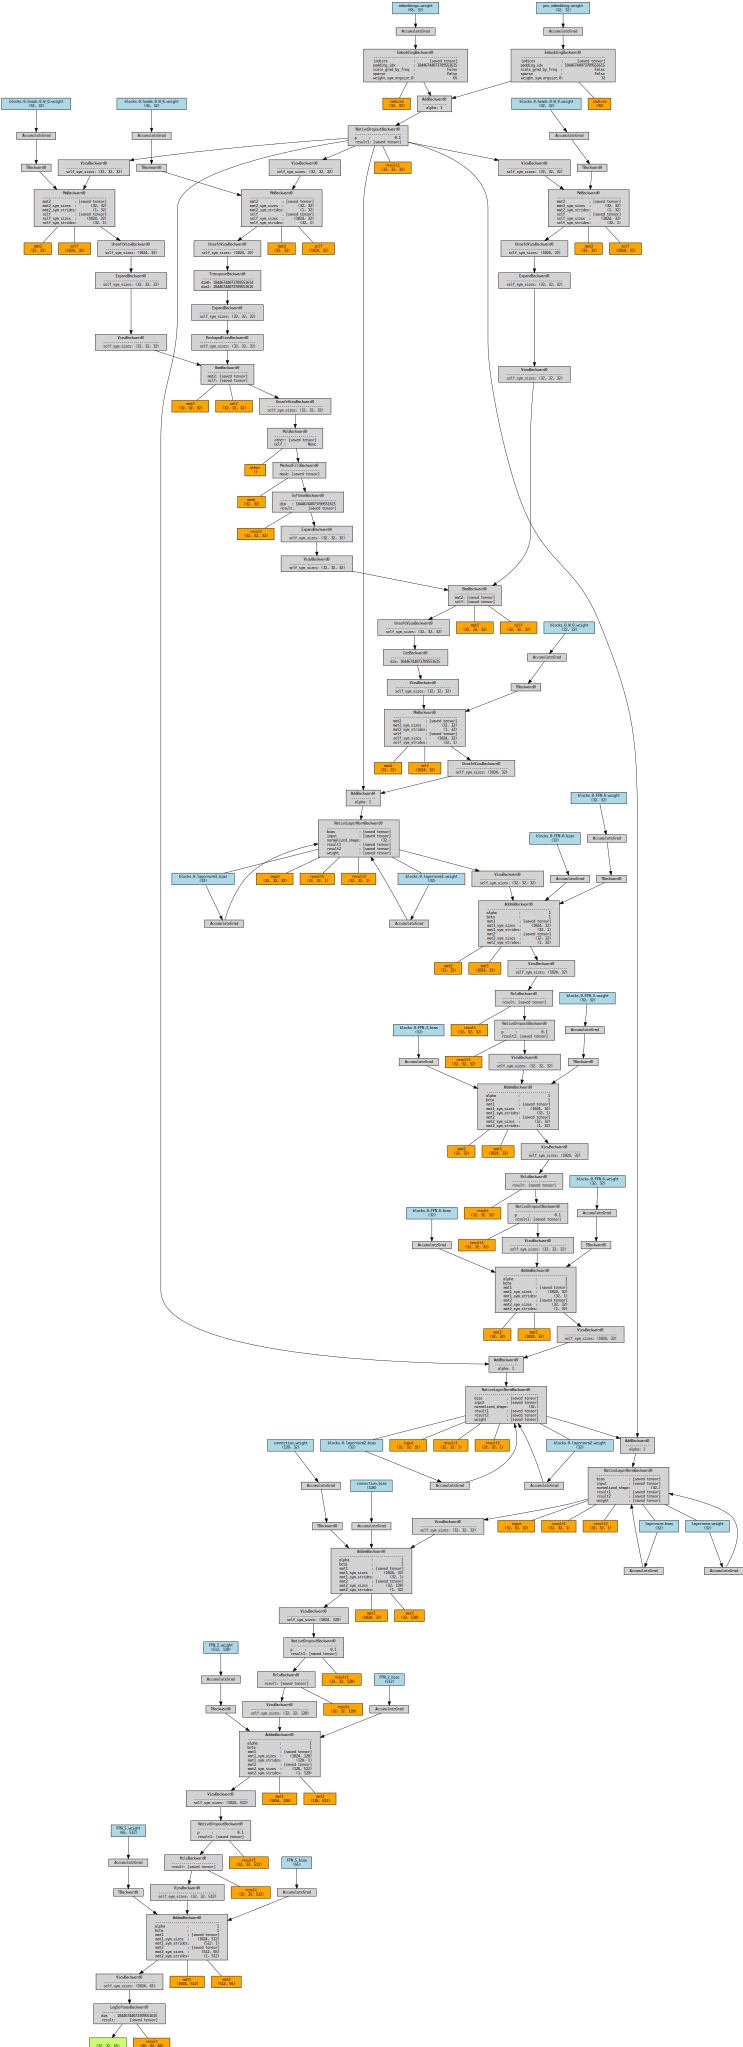

In [66]:
model = Decoder(num_blocks=1, d_model=32, vocab_size=len(chars), num_heads=1, d_hidden=128, final_dmodel=1024)
model.to(DEVICE)
x, y = batch("train")
make_dot(model(x), params=dict(list(model.named_parameters())), show_attrs=1, show_saved=1)

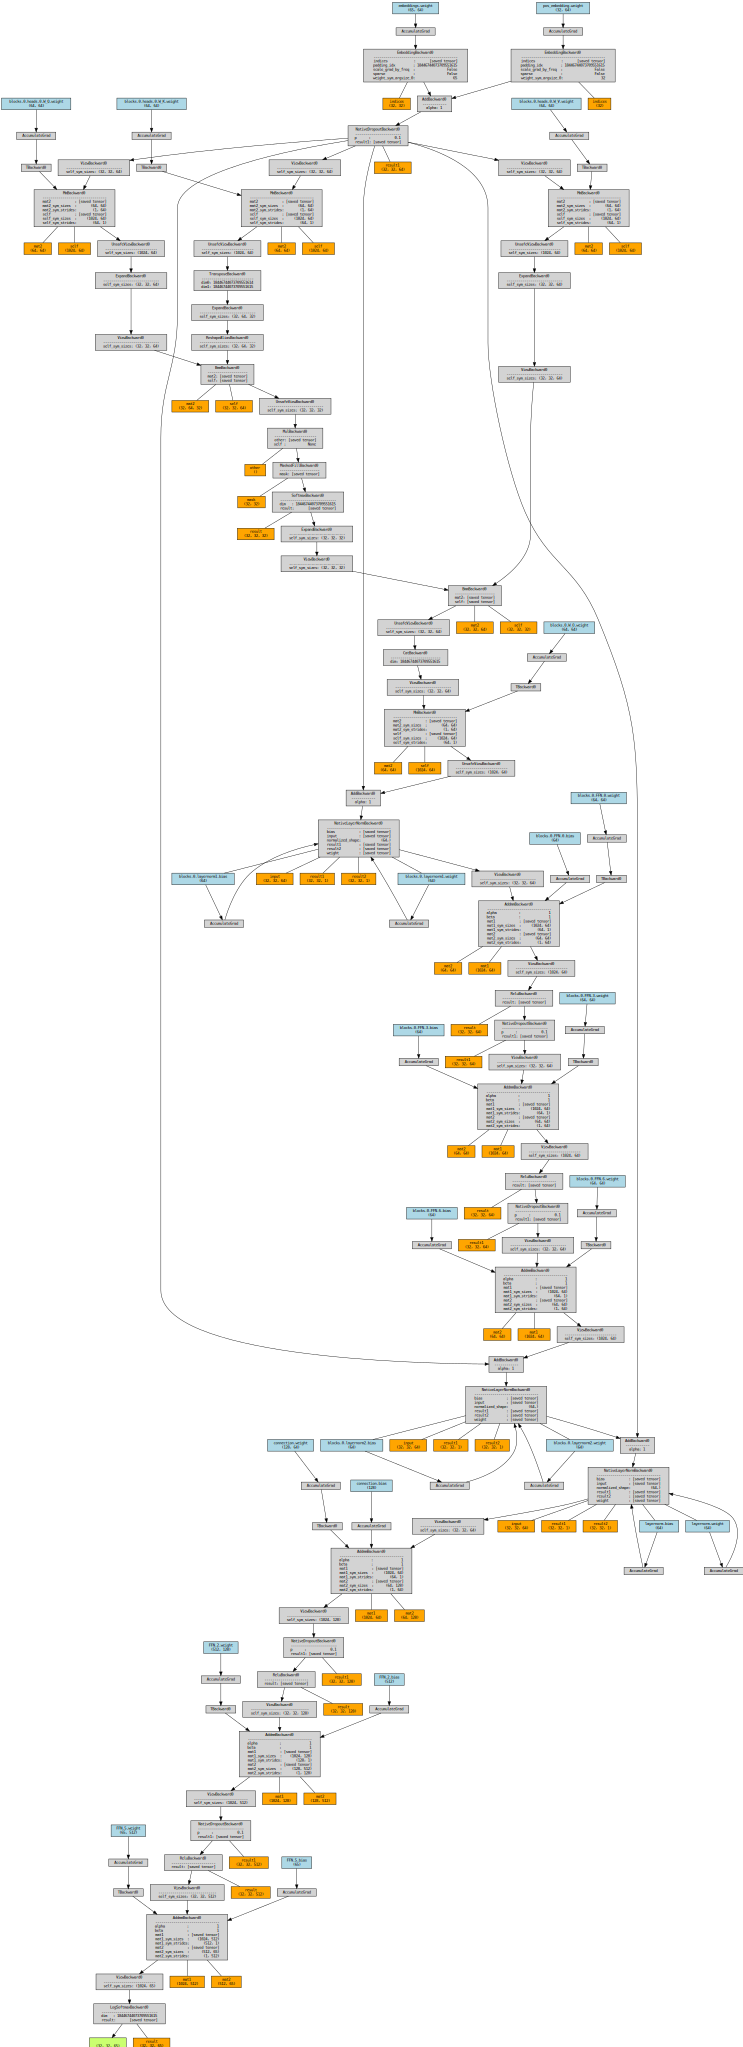

In [67]:
model.expand(64)
x, y = batch("train")
make_dot(model(x), params=dict(list(model.named_parameters())), show_attrs=1, show_saved=1)